# Obtain Optimal Probability Threshold Using ROC Curve

The aim of this notebook is to demonstrate how to use the ROC curve to obtain optimal probability threshold to improve the predictive capability of a machine learning model.

Also, **thresholder**, a Python package that I have created, which uses the ROC Curve to obtain optimal probability threshold to improve the predictive capability of a machine learning model, can obtain these thresholds and subsequent predictions easily.

The package can be found at the following Github Repo:

https://github.com/nicholaslaw/roc-optimal-cutoff

## Table of Contents

1. [Import Packages](#1)
2. [Import Data](#2)
3. [Extracting X, Y](#3)
4. [Preprocess Texts](#4)
5. [Train Test Split](#5)
6. [Feature Extraction and Train Model](#6)
7. [Evaluate Model (Before Thresholding)](#7)
8. [Confusion Matrix of Model (Before Thresholding)](#8)
9. [ROC Curve](#9)
10. [Obtain Optimal Probability Thresholds with ROC Curve](#10)
11. [Evaluate Model (After Thresholding)](#11)
12. [Confusion Matrix of Model (After Thresholding)](#12)
13. [Conclusion](#13)
14. [References](#14)

## Import Packages <a class="anchor" id="1"></a>

In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


## Import Data <a class="anchor" id="2"></a>

With respect to the dataset, we will only focus on the columns named "Phrase" and "Sentiment". The unique values in "Sentiment" are 0, 1, 2, 3, 4, where increasing values would represent more positive sentiment. Hence, this would make this a binary classification problem.

**For this notebook, we shall just focus on the training set as the main objective is to showcase the retrieval of optimal probability thresholds using the ROC Curve.**

In [2]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip", sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
print("Unique Values of Sentiment are: {}".format(", ".join(list(map(str,df["Sentiment"].unique())))))

Unique Values of Sentiment are: 1, 2, 3, 4, 0


## Extracting X, Y <a class="anchor" id="3"></a>

For this dataset, we shall let sentiment values above 2 represent positive ones. As a result, positive movie reviews make up less than 50% of the dataset. 

In [4]:
X = df["Phrase"].tolist()
Y = df["Sentiment"].apply(lambda i: 0 if i <= 2 else 1)

In [5]:
Y.value_counts()

0    113927
1     42133
Name: Sentiment, dtype: int64

## Preprocess Texts <a class="anchor" id="4"></a>

Some typical text preprocessing steps will be performed:

1. Removal of markup, html
2. Obtain only words in lower case
3. Lemmatization
4. Removal of stop words

In [6]:
lemmatizer = WordNetLemmatizer()
def proc_text(messy): #input is a single string
    first = BeautifulSoup(messy, "lxml").get_text() #gets text without tags or markup, remove html
    second = re.sub("[^a-zA-Z]"," ",first) #obtain only letters
    third = second.lower().split() #obtains a list of words in lower case
    fourth = set([lemmatizer.lemmatize(str(x)) for x in third]) #lemmatizing
    stops = set(stopwords.words("english")) #faster to search through a set than a list
    almost = [w for w in fourth if not w in stops] #remove stop words
    final = " ".join(almost)
    return final

In [7]:
X = [proc_text(i) for i in X]

## Train Test Split <a class="anchor" id="5"></a>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=100, test_size=0.2, stratify=Y)
print("Training Set has {} Positive Labels and {} Negative Labels".format(sum(y_train), len(y_train) - sum(y_train)))
print("Test Set has {} Positive Labels and {} Negative Labels".format(sum(y_test), len(y_test) - sum(y_test)))

Training Set has 33706 Positive Labels and 91142 Negative Labels
Test Set has 8427 Positive Labels and 22785 Negative Labels


## Feature Extraction and Train Model <a class="anchor" id="6"></a>

Features will be built using tfidf.

Model selected here is the RandomForestClassifier, larger weight is given to the positive class since the number of samples with positive labels are significantly smaller. The weights would be calculated as 

$$ W_p = \frac{N_n}{N_p}, $$

where $ W_p $ is a float indicating the weight for positive class, $ N_n $ is the number of negative samples and $ N_p $ is the number of positive samples. The output of this computation will be included in the *class_weight* parameter of DecisionTreeClassifier.

These steps will be collated by using sklearn's Pipeline.

In [9]:
pos_weights = (len(y_train) - sum(y_train)) / (sum(y_train)) 
pipeline_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(random_state=100, class_weight={0: 1, 1: pos_weights}))
])

In [10]:
pipeline_tf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0,
                                        class_weight={0: 1,
                                                      1: 2.7040289562689135},
                                        criterion='gini', max_depth=None,
    

## Evaluate Model (Before Thresholding) <a class="anchor" id="7"></a>

In [11]:
predictions = pipeline_tf.predict(X_test)
predicted_proba = pipeline_tf.predict_proba(X_test)

In [12]:
print("Accuracy Score Before Thresholding: {}".format(accuracy_score(y_test, predictions)))
print("Precision Score Before Thresholding: {}".format(precision_score(y_test, predictions)))
print("Recall Score Before Thresholding: {}".format(recall_score(y_test, predictions)))
print("F1 Score Before Thresholding: {}".format(f1_score(y_test, predictions)))
print("ROC AUC Score: {}".format(roc_auc_score(y_test, predicted_proba[:, -1])))

Accuracy Score Before Thresholding: 0.827277970011534
Precision Score Before Thresholding: 0.6602279924002533
Recall Score Before Thresholding: 0.7422570309718761
F1 Score Before Thresholding: 0.6988436400201106
ROC AUC Score: 0.8129862348519299


## Confusion Matrix of Model (Before Thresholding) <a class="anchor" id="8"></a>

In [13]:
y_actual = pd.Series(y_test, name='Actual')
y_predict_tf = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

Predicted     0     1   All
Actual                     
0          3281  1440  4721
1          1057   529  1586
All        4338  1969  6307


## ROC Curve <a class="anchor" id="9"></a>

The curve is plots values of true positive rates (y-axis) against those of false positive rates (x-axis) and these values are plotted at various probability thresholds.

There can be two ways of obtaining a more optimal probability threshold for the positive class:

1. Youden's J Statistic
    - Its computed as $$ J = True Positive Rate + True Negative Rate - 1 = True Positive Rate - False Positive Rate $$
    - Find the maximum difference between true positive rate and false positive rate and the probability threshold tied tagged to this largest difference would be the selected one
2. Euclidean Distance
    - The most optimal ROC curve would be one that leans towards the top left of the plot, i.e. true positive rate of 1 and false positive rate of 0.
    - Select the probability threshold as the most optimal one if its true positive rate and false positive rate are closest to the ones mentioned in the previous point in terms of Euclidean distance, i.e. $$ d(tpr, fpr) = \sqrt{({tpr_1 - tpr_2})^{2} + {fpr_1 - fpr_2})^{2}}. $$

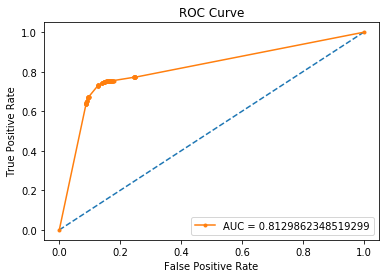

In [14]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predicted_proba[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, predicted_proba[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

## Obtain Optimal Probability Thresholds with ROC Curve <a class="anchor" id="10"></a>

In this notebook, we will be using the Youden's J statistic to obtain the optimal probability threshold and this method gives equal weights to both false positives and false negatives.

In [15]:
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]

## Evaluate Model (After Thresholding) <a class="anchor" id="11"></a>

We can see that the optimal probability threshold managed to suppress the number of false positives

In [16]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, predictions), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, predictions), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, predictions), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, predictions), f1_score(y_test, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.827277970011534, 0.8339741125208253
Precision Score Before and After Thresholding: 0.6602279924002533, 0.6785124876224007
Recall Score Before and After Thresholding: 0.7422570309718761, 0.731814406075709
F1 Score Before and After Thresholding: 0.6988436400201106, 0.7041562000456725


## Confusion Matrix of Model (After Thresholding) <a class="anchor" id="12"></a>

We can see that the new predictions have fewer false positives but more false negatives in the process. F1 score and accuracy have improved.

In [17]:
y_actual = pd.Series(y_test, name='Actual')
y_predict_tf = pd.Series(roc_predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Predicted     0     1   All
Actual                     
0          3323  1398  4721
1          1080   506  1586
All        4403  1904  6307


## Conclusion <a class="anchor" id="13"></a>

Obtaining optimal probability thresholds using the ROC curves is one way of maximizing the predictive capability of your machine learning model. There are a few ways of obtaining these thresholds and they have different assumptions, so please choose wisely. 

Again, please take a look at the Python package, *thresholder*, I have created which could make the generation of predictions based on the optimal thresholds obtained by the ROC curve convenient and easy. 

## References <a class="anchor" id="14"></a>

- https://github.com/nicholaslaw/roc-optimal-cutoff
- https://en.wikipedia.org/wiki/Youden%27s_J_statistic